In [1]:
import numpy as np
import sys
import os
import numpy as np
from sklearn.cluster import KMeans
import json
import random
import networkx as nx
import matplotlib.pyplot as plt


class CIBR(object):
    def __init__(self, dataset, n_branches, depth):
        self.dataset = dataset
        self.n_branches = n_branches
        self.depth = depth
        self.tree = {}
        self.nodes = {}
        self.leaves = {}
        
        # private:
        self._current_index = 0
        
        # build graph
        self.graph = nx.DiGraph()
        self.fit()
        for k, v in self.tree.items():
            self.graph.add_node(k, w=1)
            for link in v:
                self.graph.add_edge(k, link)
        
        # compute inverted index
#         self.index()
        return
    
    def extract_features(self, image=None):
        # dummy features to test
        # replace with Antonio's 
        if (image is None):
            ones = np.ones(1)
#             return np.array([ones, ones * 2, ones * 10, ones * 11])
            return np.random.randn(4000, 128)
        else:
            return sift(image)

    def get_image_id(self, image_path):
        """
        Given an image path, returns the id of the image: the numerical part of the filename
        Args:
            image_path (str): path of the image
        Returns:
            (str): the id of the image as string
        """
        return os.path.splitext(os.path.basename(image_path))[0]

    def fit(self, features=None, node=0, root=None, current_depth=0):
        """
        Generates a hierarchical vocabulary tree representation of some input features
        using hierarchical k-means clustering.
        This function populates two class fields:
            `self.tree`, as Dict[int, List[int]], where the key is the id of the root node
        and the value is a list of children nodes, and
             `self.nodes` as a dictionary Dict[int, numpy.ndarray] that stores the actual value for each node
        Args:
            features (numpy.ndarray): a two dimensional vector of input features where dim 0 is samples and dim 1 is features
            node (int): current node id to set
            root (numpy.ndarray): the value of the parent of the `node` as a virtual feature
            current_depth (int): the depth of the node as the distance in jumps from the very root of the tree
        """
        if features is None:
            features = self.extract_features()
        if root is None:
            root = np.mean(features)
        
        self.nodes[node] = root
        self.graph.add_node(node)
        
        # if `node` is a leaf node, return
        if current_depth >= self.depth or len(features) < self.n_branches:
            # initialise leaves
            self.leaves[node] = {}
            return
        
        # group features by cluster
        model = KMeans(n_clusters=self.n_branches)
        model.fit(features)
        children = [[] for i in range(self.n_branches)]
        for i in range(len(features)):
            children[model.labels_[i]].append(features[i])
        
        # cluster children
        self.tree[node] = []
        for i in range(self.n_branches):
            self._current_index += 1
            self.tree[node].append(self._current_index)
            self.graph.add_edge(node, self._current_index)
            self.fit(children[i], self._current_index, model.cluster_centers_[i], current_depth + 1)
        return
    
    def index(self):
        """
        Generates the inverted index structure using tf-idf.
        This function also calculates the weights for each node as entropy. 
        """
        # create inverted index
        for image_path in self.dataset.all_images:
            self.encode(image_path, return_graph=False)
            
        # set weights of node based on entropy
        N = len(self.dataset)
        for node_id, files in self.graph.nodes(data=True):
            N_i = len(files)
            if N_i:  # if the node is visited, calculate the weight, otherwise, leave it as initialised
                self.graph.nodes[node_id]["w"] = np.log(N / N_i)  # calculate entropy
        return
    
    def encode(self, image_path):
        """
        Encodes an image into a set of paths on the tree.
        The vector representation is the values list of a key value pair,
        where the key is the id of the node and the value is the number of times that node is visited during propagation.
        This results into an tf-idf scheme.
        Args:
            image_path (str): path of the image to encode
        Return:
            (networkx.DiGraph): The tree representing the encoded image
        """
        points, features = self.extract_features(image_path)
        image_id = self.get_image_id(image_path)
        for feature in features:
            path = self.propagate_feature(feature)
            for i in range(len(path)):
                node = path[i]
                # this automatically skips if node is already there, so attributes are preserved
                self.graph.add_node(node)
                # add tfidf
                if image_id not in self.graph.nodes[node]:
                    self.graph.nodes[node][image_id] = 1
                else:
                    self.graph.nodes[node][image_id] += 1
                # add links
                if i != len(path) - 2:
                    self.graph.add_path(path[i], path[i + 1])
        return self.get_encoded(image_id)

    def propagate_feature(self, feature, node=0):
        """
        Propagates a feature, down the tree, and returns the closest node.
        Args:
            feature (numpy.ndarray): The feature to lookup
            root (int): Node id to start the search from.
                        Default is 0, meaning the very root of the tree
        """
        min_dist = float("inf")
        path = [node]
        while len(self.tree[node]) != 0:  #recur
            for child in self.tree[node]:
                distance = np.linalg.norm([self.nodes[child] - feature])  # l1 norm 
                if distance < min_dist:
                    min_dist = distance
                    node = child
                    path.append(child)
        return path

    def get_encoded(self, image_id, return_graph=True):
        subgraph = self.graph.subgraph([k for k, v in a.nodes(data=image_id, default=None) if v is not None])
        if return_graph:
            return subgraph
        weights = np.array(subgraph.nodes(data="w"))
        tfidf = np.array(subgraph.nodes(data=image_id))
        tfidf = tfidf / np.linalg.norm(tfidf)  # l2 norm
        return tfidf * weights

    def score(self, database_image_path, query_image_path):
        """
        Measures the similatiries between the set of paths of the features of each image.
        """
        db_id = self.get_image_id(database_image_path)
        query_id = self.get_image_id(query_image_path)
        
        # propagate the query down the tree
        self.encode(query_image_path)
        
        # get the vectors of the images
        d = self.get_encoded(db_id, return_graph=False)
        q = self.get_encoded(query_id, return_graph=False)
        
        # simplified scoring using the l2 norm
        score = 2 - 2 * np.sum(d * q)
        return score
        
    def retrieve(self, query_image_path, n=4):
        scores = {}
        for database_image_path in self.dataset.all_images:
            db_id = self.get_image_id(database_image_path)
            scores[db_id] = self.score(database_image_path, query_image_path)
        sorted_scores = sorted(scores, key=scores.__getitem__)
        return scores.keys()[:n]
    
    def draw(self, figsize=None):
        figsize = (30, 10) if figsize is None else figsize
        plt.figure(figsize=figsize)
        pos = nx.drawing.nx_agraph.graphviz_layout(self.graph, prog='dot')
        nx.draw(self.graph, pos=pos)


In [2]:
vv3 = CIBR(None, 3, 5)

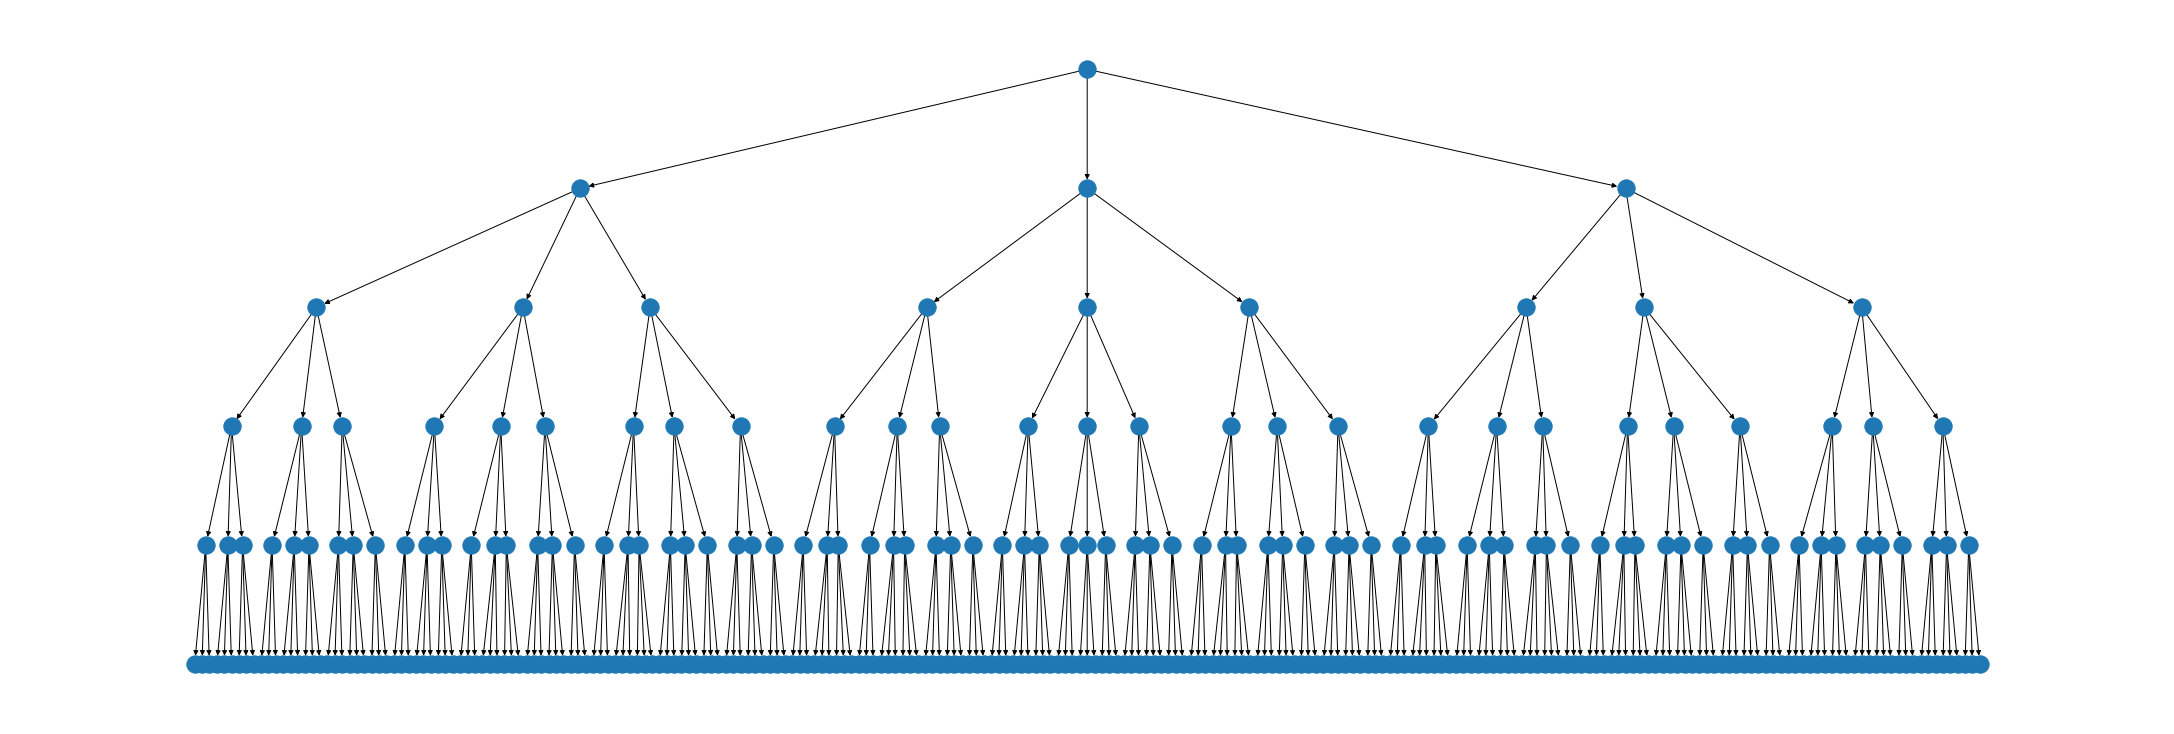

In [3]:
vv3.draw()

In [4]:
vv3.graph.nodes(data=True)

NodeDataView({0: {'w': 1}, 1: {'w': 1}, 2: {'w': 1}, 3: {'w': 1}, 4: {'w': 1}, 5: {}, 6: {}, 7: {}, 8: {'w': 1}, 9: {}, 10: {}, 11: {}, 12: {'w': 1}, 13: {}, 14: {}, 15: {}, 16: {'w': 1}, 17: {'w': 1}, 18: {}, 19: {}, 20: {}, 21: {'w': 1}, 22: {}, 23: {}, 24: {}, 25: {'w': 1}, 26: {}, 27: {}, 28: {}, 29: {'w': 1}, 30: {'w': 1}, 31: {}, 32: {}, 33: {}, 34: {'w': 1}, 35: {}, 36: {}, 37: {}, 38: {'w': 1}, 39: {}, 40: {}, 41: {}, 42: {'w': 1}, 43: {'w': 1}, 44: {'w': 1}, 45: {}, 46: {}, 47: {}, 48: {'w': 1}, 49: {}, 50: {}, 51: {}, 52: {'w': 1}, 53: {}, 54: {}, 55: {}, 56: {'w': 1}, 57: {'w': 1}, 58: {}, 59: {}, 60: {}, 61: {'w': 1}, 62: {}, 63: {}, 64: {}, 65: {'w': 1}, 66: {}, 67: {}, 68: {}, 69: {'w': 1}, 70: {'w': 1}, 71: {}, 72: {}, 73: {}, 74: {'w': 1}, 75: {}, 76: {}, 77: {}, 78: {'w': 1}, 79: {}, 80: {}, 81: {}, 82: {'w': 1}, 83: {'w': 1}, 84: {'w': 1}, 85: {}, 86: {}, 87: {}, 88: {'w': 1}, 89: {}, 90: {}, 91: {}, 92: {'w': 1}, 93: {}, 94: {}, 95: {}, 96: {'w': 1}, 97: {'w': 1}, 98

In [5]:
list(dict(vv3.graph.nodes(data=True, default=1)).values())

[{'w': 1},
 {'w': 1},
 {'w': 1},
 {'w': 1},
 {'w': 1},
 {},
 {},
 {},
 {'w': 1},
 {},
 {},
 {},
 {'w': 1},
 {},
 {},
 {},
 {'w': 1},
 {'w': 1},
 {},
 {},
 {},
 {'w': 1},
 {},
 {},
 {},
 {'w': 1},
 {},
 {},
 {},
 {'w': 1},
 {'w': 1},
 {},
 {},
 {},
 {'w': 1},
 {},
 {},
 {},
 {'w': 1},
 {},
 {},
 {},
 {'w': 1},
 {'w': 1},
 {'w': 1},
 {},
 {},
 {},
 {'w': 1},
 {},
 {},
 {},
 {'w': 1},
 {},
 {},
 {},
 {'w': 1},
 {'w': 1},
 {},
 {},
 {},
 {'w': 1},
 {},
 {},
 {},
 {'w': 1},
 {},
 {},
 {},
 {'w': 1},
 {'w': 1},
 {},
 {},
 {},
 {'w': 1},
 {},
 {},
 {},
 {'w': 1},
 {},
 {},
 {},
 {'w': 1},
 {'w': 1},
 {'w': 1},
 {},
 {},
 {},
 {'w': 1},
 {},
 {},
 {},
 {'w': 1},
 {},
 {},
 {},
 {'w': 1},
 {'w': 1},
 {},
 {},
 {},
 {'w': 1},
 {},
 {},
 {},
 {'w': 1},
 {},
 {},
 {},
 {'w': 1},
 {'w': 1},
 {},
 {},
 {},
 {'w': 1},
 {},
 {},
 {},
 {'w': 1},
 {},
 {},
 {},
 {'w': 1},
 {'w': 1},
 {'w': 1},
 {'w': 1},
 {},
 {},
 {},
 {'w': 1},
 {},
 {},
 {},
 {'w': 1},
 {},
 {},
 {},
 {'w': 1},
 {'w': 1},
 {},
 {},
 

In [6]:
vv3.graph.nodes(data=True)

NodeDataView({0: {'w': 1}, 1: {'w': 1}, 2: {'w': 1}, 3: {'w': 1}, 4: {'w': 1}, 5: {}, 6: {}, 7: {}, 8: {'w': 1}, 9: {}, 10: {}, 11: {}, 12: {'w': 1}, 13: {}, 14: {}, 15: {}, 16: {'w': 1}, 17: {'w': 1}, 18: {}, 19: {}, 20: {}, 21: {'w': 1}, 22: {}, 23: {}, 24: {}, 25: {'w': 1}, 26: {}, 27: {}, 28: {}, 29: {'w': 1}, 30: {'w': 1}, 31: {}, 32: {}, 33: {}, 34: {'w': 1}, 35: {}, 36: {}, 37: {}, 38: {'w': 1}, 39: {}, 40: {}, 41: {}, 42: {'w': 1}, 43: {'w': 1}, 44: {'w': 1}, 45: {}, 46: {}, 47: {}, 48: {'w': 1}, 49: {}, 50: {}, 51: {}, 52: {'w': 1}, 53: {}, 54: {}, 55: {}, 56: {'w': 1}, 57: {'w': 1}, 58: {}, 59: {}, 60: {}, 61: {'w': 1}, 62: {}, 63: {}, 64: {}, 65: {'w': 1}, 66: {}, 67: {}, 68: {}, 69: {'w': 1}, 70: {'w': 1}, 71: {}, 72: {}, 73: {}, 74: {'w': 1}, 75: {}, 76: {}, 77: {}, 78: {'w': 1}, 79: {}, 80: {}, 81: {}, 82: {'w': 1}, 83: {'w': 1}, 84: {'w': 1}, 85: {}, 86: {}, 87: {}, 88: {'w': 1}, 89: {}, 90: {}, 91: {}, 92: {'w': 1}, 93: {}, 94: {}, 95: {}, 96: {'w': 1}, 97: {'w': 1}, 98

In [7]:
vv3.tree

{0: [1, 122, 243],
 1: [2, 42, 82],
 2: [3, 16, 29],
 3: [4, 8, 12],
 4: [5, 6, 7],
 8: [9, 10, 11],
 12: [13, 14, 15],
 16: [17, 21, 25],
 17: [18, 19, 20],
 21: [22, 23, 24],
 25: [26, 27, 28],
 29: [30, 34, 38],
 30: [31, 32, 33],
 34: [35, 36, 37],
 38: [39, 40, 41],
 42: [43, 56, 69],
 43: [44, 48, 52],
 44: [45, 46, 47],
 48: [49, 50, 51],
 52: [53, 54, 55],
 56: [57, 61, 65],
 57: [58, 59, 60],
 61: [62, 63, 64],
 65: [66, 67, 68],
 69: [70, 74, 78],
 70: [71, 72, 73],
 74: [75, 76, 77],
 78: [79, 80, 81],
 82: [83, 96, 109],
 83: [84, 88, 92],
 84: [85, 86, 87],
 88: [89, 90, 91],
 92: [93, 94, 95],
 96: [97, 101, 105],
 97: [98, 99, 100],
 101: [102, 103, 104],
 105: [106, 107, 108],
 109: [110, 114, 118],
 110: [111, 112, 113],
 114: [115, 116, 117],
 118: [119, 120, 121],
 122: [123, 163, 203],
 123: [124, 137, 150],
 124: [125, 129, 133],
 125: [126, 127, 128],
 129: [130, 131, 132],
 133: [134, 135, 136],
 137: [138, 142, 146],
 138: [139, 140, 141],
 142: [143, 144, 145],